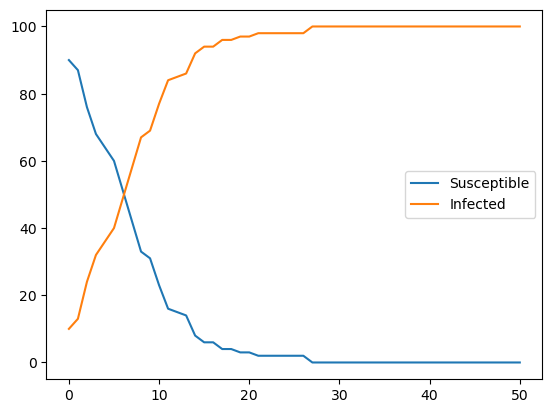

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def tau_leaping(S, c, X0, T, tau):
    """
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    t = 0.0
    X = []
    X.append(X0)
    i = 0

    for j in range(T):
        a = c*np.array([X[i][0]*X[i][1], X[i][0]])  # Propensity function
        K = np.random.poisson(a * tau)  # Number of reactions
        X_new = X[i] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t += tau  # Update the time
        i = i+1

        # Check for negative populations
        if np.any(X[i] < 0):
            raise ValueError("Negative population")

    return X

# Example usage:
S = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 50  # Total time
tau = 0.3  # Leap size

X = tau_leaping(S, c, X0, T, tau)
plt.plot(range(len(X)), np.array(X)[:,0], label='Susceptible')
plt.plot(range(len(X)), np.array(X)[:,1], label='Infected')
plt.legend()